In [53]:
import tensorflow as tf
print(tf.__version__)

from sklearn.datasets import load_diabetes

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [54]:
# Load the diabetes dataset

diabets_dataset =load_diabetes()
print (diabets_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [55]:
# Save the input and target variables

diabets_dataset.keys()

data = diabets_dataset['data']
target = diabets_dataset['target']

In [56]:
# Normalise the target data (this will make clearer training curves)

target = (target - target.mean(axis =0) / target.std())

In [57]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_target = train_test_split(data, target, test_size = 0.1)

#### Train a feedforward neural network model

In [58]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation = 'relu', input_shape = (train_data.shape[1],)),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(1)])
    return model

model = get_model()    

In [59]:
# Print the model summary

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_54 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                

In [60]:
# Compile the model

model.compile(optimizer='adam', loss = 'mae', metrics = ['mae'])


In [61]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15,
                   batch_size=64,
                   verbose=False)


In [62]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target, verbose=False)

[39.94879404703776, 39.948795]

#### Plot the learning curves

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

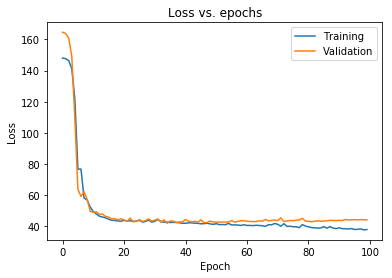

In [64]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [65]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [66]:
def get_regularised_model(wt1,wt2, rate):
    model = Sequential([
        Dense(128, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=wt1, l2=wt2),activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=wt1, l2=wt2),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=wt1, l2=wt2),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=wt1, l2=wt2),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=wt1, l2=wt2),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=wt1, l2=wt2),activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [67]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-2,1e-2,0.3)

In [68]:
# Compile the model

model.compile(optimizer='adam', loss= 'mae', metrics=['mae'])

In [69]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)

In [70]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target, verbose=False)

[51.69597574869792, 42.637276]

#### Plot the learning curves

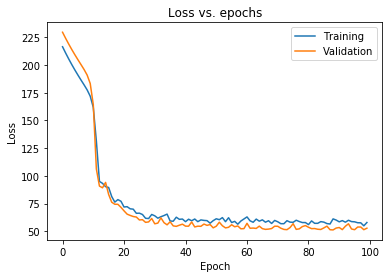

In [71]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [72]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs =None):
    
        print ("Starting Training...")
        
    def on_epoch_begin(self, epoch, logs = None):
        
        print (f"Starting epoch {epoch}")
               
    def on_train_batch_begin(self, batch, logs = None):
               
        print (f"Training: Starting batch {batch}")
    
    def on_train_batch_end(self, batch, logs =None):
               
        print(f"Training: Finished btach {batch}")
        
    def on_epoch_end(self, epoch, logs = None):
        
        print (f"Finished epoch {epoch}")
        
    def on_train_end(self, logs = None):
        
        print ("Finished Training...")
        

In [73]:
# Re-build the model

model = get_regularised_model(1e-2, 1e-2, 0.3)

In [74]:
# Compile the model

model.compile(optimizer='adam', loss = 'mae')

#### Train the model with the callback

In [75]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose =False, callbacks=[TrainingCallback()])


Starting Training...
Starting epoch 0
Training: Starting batch 0
Training: Finished btach 0
Training: Starting batch 1
Training: Finished btach 1
Training: Starting batch 2
Training: Finished btach 2
Training: Starting batch 3
Training: Finished btach 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished btach 0
Training: Starting batch 1
Training: Finished btach 1
Training: Starting batch 2
Training: Finished btach 2
Training: Starting batch 3
Training: Finished btach 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished btach 0
Training: Starting batch 1
Training: Finished btach 1
Training: Starting batch 2
Training: Finished btach 2
Training: Starting batch 3
Training: Finished btach 3
Finished epoch 2
Finished Training...


In [76]:
# Evaluate the model

model.evaluate(test_data, test_target, verbose=False)

205.7753173828125

In [77]:
# Make predictions with the model

model.predict(test_data, verbose=False)

array([[0.23775958],
       [0.2459532 ],
       [0.23749888],
       [0.24428731],
       [0.24330999],
       [0.24469516],
       [0.242532  ],
       [0.24291432],
       [0.24560136],
       [0.24041426],
       [0.2396433 ],
       [0.24284232],
       [0.2422126 ],
       [0.23747484],
       [0.24236818],
       [0.24106258],
       [0.24814947],
       [0.23701274],
       [0.24689174],
       [0.2415712 ],
       [0.23648591],
       [0.23882276],
       [0.24269888],
       [0.23355569],
       [0.24105074],
       [0.24312015],
       [0.24092503],
       [0.24602516],
       [0.23775227],
       [0.23762953],
       [0.23759808],
       [0.24064173],
       [0.24543409],
       [0.24256758],
       [0.24248977],
       [0.24326144],
       [0.23642816],
       [0.24389312],
       [0.24386919],
       [0.24176773],
       [0.24339314],
       [0.24195147],
       [0.24107127],
       [0.24246189],
       [0.23690186]], dtype=float32)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [80]:
# Re-train the unregularised model

unreqularized_model = get_model()
unreqularized_model.compile(optimizer = 'adam', loss = 'mse')
unreq_history = unreqularized_model.fit(train_data, train_targets, epochs = 100, validation_split = 0.15,
                                        batch_size = 64, verbose = False,callbacks = [tf.keras.callbacks.EarlyStopping()])


In [81]:
# Evaluate the model on the test set
unreqularized_model.evaluate(test_data,test_target,verbose = False)

4895.248209635417

In [83]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-8, 1e-8,0.2)
regularized_model.compile(optimizer = 'adam', loss = 'mse')
reg_history = regularized_model.fit(train_data, train_targets, epochs = 100,
                                   validation_split = 0.15, batch_size = 64, 
                                   verbose = False,
                                   callbacks = [tf.keras.callbacks.EarlyStopping()])

In [84]:
# Evaluate the model on the test set

regularized_model.evaluate(test_data, test_target, verbose = False)

5579.514702690973

#### Plot the learning curves

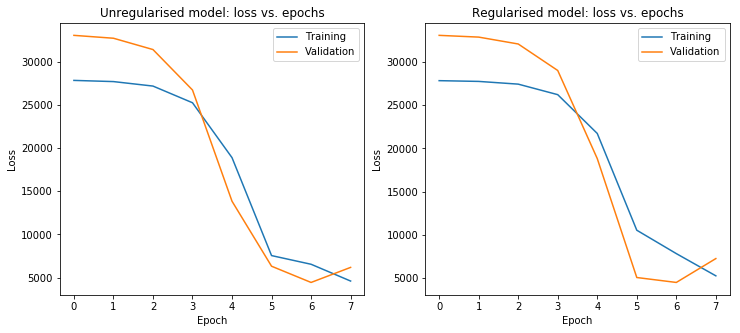

In [86]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreq_history.history['loss'])
plt.plot(unreq_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()